# Analysis of one scene

In [1]:
import numpy as np
from scipy import linalg
import json
import os
import cv2
from pupil_apriltags import Detector
from scipy.spatial.transform import Rotation
from matplotlib import pyplot as plt
%matplotlib inline

Before you begin, rename `1616792742.72.txt` to `poses.json` and put everything in brackets like this:
```
[
    [xxx, xxx, ..., xxx],
    [xxx, xxx, ..., xxx],
    ...
    [xxx, xxx, ..., xxx]
]
```

Contruct intrinsic parameters and standard projection (with data copied from `yaml` file because I didn't want to parse it).

For RealSense, run `rostopic echo /camera/color/camera_info` to retrieve the camera intrinsics.

In [2]:
# camera = {
#     "fx": 22073.91484115231,
#     "fy": 22014.38979938558,
#     "ox": 2997.956918939165,
#     "oy": 1445.945186976369,
#     "w": 5472,
#     "h": 3648
# }
# top-down view RealSense D415
# camera = {
#     "fx": 612.2998046875,
#     "fy": 612.0841674804688,
#     "ox": 320.2190856933594,
#     "oy": 238.19973754882812,
#     "w": 640,#5472, # image width
#     "h": 480,#3648, # image height
# }
# K: [612.2998046875, 0.0, 320.2190856933594, 0.0, 612.0841674804688, 238.19973754882812, 0.0, 0.0, 1.0]
# P: [612.2998046875, 0.0, 320.2190856933594, 0.0, 0.0, 612.0841674804688, 238.19973754882812, 0.0, 0.0, 0.0, 1.0, 0.0]

# side view RealSense D435
# camera = {
#     "fx": 615.0968627929688,
#     "fy": 615.2621459960938,
#     "ox": 318.0588073730469,
#     "oy": 245.52305603027344,
#     "w": 640,#5472, # image width
#     "h": 480,#3648, # image height
# }
# K: [615.0968627929688, 0.0, 318.0588073730469, 0.0, 615.2621459960938, 245.52305603027344, 0.0, 0.0, 1.0]
# R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
# P: [615.0968627929688, 0.0, 318.0588073730469, 0.0, 0.0, 615.2621459960938, 245.52305603027344, 0.0, 0.0, 0.0, 1.0, 0.0]

## updated Apr 2022
# D435
camera = {
    "fx": 918.44970703125,
    "fy": 918.126220703125,
    "ox": 640.32861328125,
    "oy": 357.2995910644531,
    "w": 1280, # image width
    "h": 720, # image height
}

# height: 720
# width: 1280
# distortion_model: "plumb_bob"
# D: [0.0, 0.0, 0.0, 0.0, 0.0]
# K: [918.44970703125, 0.0, 640.32861328125, 0.0, 918.126220703125, 357.2995910644531, 0.0, 0.0, 1.0]
# R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
# P: [918.44970703125, 0.0, 640.32861328125, 0.0, 0.0, 918.126220703125, 357.2995910644531, 0.0, 0.0, 0.0, 1.0, 0.0]
# binning_x: 0
# binning_y: 0
# roi: 
#   x_offset: 0
#   y_offset: 0
#   height: 0
#   width: 0
#   do_rectify: False
# ---

K = np.array([[camera['fx'], 0., camera['ox']], [0., camera['fy'], camera['oy']], [0., 0., 1.]])
P = np.eye(3, 4)

Specify location of dataset.

In [3]:
basedir = '../data'
board = '2x2_alu'
scenedir = os.path.join(basedir, board)

Define template with the ID, position (cm), width (cm), and homogeneous corner locations (m) of each tag.

In [4]:
# Define template
# if board == '3x3':
#     w_mea = 2.6924  # 1.06in
#     delta_p = 3.0436    # 1.34in
#     template = [
#         { "tag_id": 0, "x": 0, "y": 0, "w": w_mea },
#         { "tag_id": 1, "x": delta_p, "y": 0, "w": w_mea },
#         { "tag_id": 2, "x": 2.0*delta_p, "y": 0, "w": w_mea  },
#         { "tag_id": 24, "x": 0, "y": -delta_p, "w": w_mea  },
#         { "tag_id": 25, "x": delta_p, "y": -delta_p, "w": w_mea  },
#         { "tag_id": 26, "x": 2.0*delta_p, "y": -delta_p, "w": w_mea  },
#         { "tag_id": 48, "x": 0, "y": -2.0*delta_p, "w": w_mea  },
#         { "tag_id": 49, "x": delta_p, "y": -2.0*delta_p, "w": w_mea  },
#         { "tag_id": 50, "x": 2.0*delta_p, "y": -2.0*delta_p, "w": w_mea  },
#     ]

if board == '3x3_alu':
    w_mea = 3  # 1.06in
    delta_p = 3.375    # 1.34in
    template = [
        { "tag_id": 0, "x": 0, "y": -2.0*delta_p, "w": w_mea },
        { "tag_id": 1, "x": delta_p, "y": -2.0*delta_p, "w": w_mea },
        { "tag_id": 2, "x": 2.0*delta_p, "y": -2.0*delta_p, "w": w_mea  },
        { "tag_id": 3, "x": 0, "y": -delta_p, "w": w_mea  },
        { "tag_id": 4, "x": delta_p, "y": -delta_p, "w": w_mea  },
        { "tag_id": 5, "x": 2.0*delta_p, "y": -delta_p, "w": w_mea  },
        { "tag_id": 6, "x": 0, "y": 0, "w": w_mea  },
        { "tag_id": 7, "x": delta_p, "y": 0, "w": w_mea  },
        { "tag_id": 8, "x": 2.0*delta_p, "y": 0, "w": w_mea  },
    ]

# elif board == '2x2':
#     w_mea = 4.0894  # 1.61in
#     delta_p = 5.1816    # 2.04in
#     template = [
#         { "tag_id": 0, "x": 0, "y": 0, "w": w_mea },
#         { "tag_id": 1, "x": delta_p, "y": 0, "w": w_mea },
#         { "tag_id": 24, "x": 0, "y": -delta_p, "w": w_mea  },
#         { "tag_id": 25, "x": delta_p, "y": -delta_p, "w": w_mea  },
#     ]
elif board == '2x2_alu':
    w_mea = 4  # 1.61in
    delta_p = 4.5    # 2.04in
    template = [
        { "tag_id": 0, "x": 0, "y": -delta_p, "w": w_mea },
        { "tag_id": 1, "x": delta_p, "y": -delta_p, "w": w_mea },
        { "tag_id": 2, "x": 0, "y": 0, "w": w_mea  },
        { "tag_id": 3, "x": delta_p, "y": 0, "w": w_mea  },
    ]

# Add corner locations to each tag in template
for tag in template:
    x = tag['x']
    y = tag['y']
    w = tag['w']
    tag['corners'] = np.array([[x, y, 0],
                               [x + w, y, 0],
                               [x + w, y + w, 0],
                               [x, y + w, 0]]) / 100

Define helper functions.

In [5]:
def get_tag_from_template(tag_id):
    for tag in template:
        if tag['tag_id'] == tag_id:
            return tag
    raise Exception(f'tag_id {tag_id} not found in template')

def to_homog(p):
    return np.hstack([p, np.ones((p.shape[0], 1))])

def twist_to_matrix(V):
    M = np.zeros((4, 4))
    M[0, 1] = -V[2]
    M[0, 2] = V[1]
    M[1, 2] = -V[0]
    M[1, 0] = V[2]
    M[2, 0] = -V[1]
    M[2, 1] = V[0]
    M[0:3, 3] = V[3:6]
    return M

def projection(T, p):
    q = K @ P @ T @ p.T
    return (q / q[2]).T

def projection_derivative(x, y, z):
    return np.array([[1. / z, 0., -x / (z**2)], [0., 1. / z, -y / (z**2)], [0., 0., 0.]])

def projection_error(T_base_in_cam, T_tag_in_ee):
    err = 0.
    for image in images:
        q = projection(T_base_in_cam @ image['T_ee_in_base'] @ T_tag_in_ee, image['p_tag'])
        err += np.sum((image['p_img'] - q)**2)
    return err

def basis_vector(n, k):
    return np.eye(n, 1, k=-k).flatten()

Get the following for each image:

* Pose of base frame in tool frame
* The `image_id` that is used to index the image and from which the image filename is derived
* The ID and corner positions of each tag in the image (https://pypi.org/project/pupil-apriltags/)
* The homogeneous coordinates of each tag corner, both in the image (2D) and in the template (3D)

Reject tags that have corners too close to the image boundary.

In [6]:
with open(os.path.join(scenedir, 'poses.json')) as f:
    poses = json.load(f)

images = []
for pose in poses:
    
    # Get the pose of the base frame with respect to the tool frame,
    # assuming that each line of pose data has the following format:
    #
    #  t, x, y, z, qx, qy, qz, qw, ...
    #
    p = np.array(pose[1:4]).reshape((-1, 1))
    R = Rotation.from_quat(pose[4:8]).as_matrix()
    T_ee_in_base = np.block([[R, p], [0., 0., 0., 1.]])
    
    # Get the image_id
    image_id = f'{np.round(pose[0], decimals=2)}'
    
    # Read image and detect tags, rejecting any tag that has corners
    # closer than buffer_px to the image boundary (the detector often
    # includes tags whose true corners are outside the image, but with
    # these corners relocated to the boundary of the image).
    im = cv2.imread(os.path.join(scenedir, f'{image_id}.png'), cv2.IMREAD_GRAYSCALE)
    tag_detector = Detector(families='tag36h11',
                            nthreads=1,
                            quad_decimate=1.0,
                            quad_sigma=0.0,
                            refine_edges=1,
                            decode_sharpening=0.25,
                            debug=0)
    tag_detections = tag_detector.detect(im,
                                         estimate_tag_pose=False,
                                         camera_params=None,
                                         tag_size=None)
    rejected_tags = []
    tags = []
    buffer_px = 5
    for d in tag_detections:
        if ((d.corners[:, 0] < buffer_px).any() or
            (d.corners[:, 0] > im.shape[1] - buffer_px).any() or
            (d.corners[:, 1] < buffer_px).any() or
            (d.corners[:, 1] > im.shape[0] - buffer_px).any()):
            rejected_tags.append(d.tag_id)
            continue
        tags.append({
            'tag_id': d.tag_id,
            'corners': d.corners,
        })
    num_tags = len(tags)
    
    # Get n point correspondences:
    #
    #  p_img (n x 3) is homogeneous coordinates of each point in the image frame
    #  p_tag (n x 4) is homogeneous coordinates of each point in the tag frame
    #
    p_tag = []
    p_img = []
    
    for tag in tags:
        if tag['tag_id'] not in [0,1,2,3]:
            # added to filter out wrong detections
            continue
#         print(tag['tag_id'])
        p_img.extend(tag['corners'].tolist())
        p_tag.extend(get_tag_from_template(tag['tag_id'])['corners'].tolist())
    p_tag = to_homog(np.array(p_tag))
    p_img = to_homog(np.array(p_img))
    num_points = p_img.shape[0]
    
    images.append({
        'T_ee_in_base': T_ee_in_base,
        'image_id': image_id,
        'num_tags': num_tags,
        'tags': tags,
        'num_points': num_points,
        'p_img': p_img,
        'p_tag': p_tag,
    })
    
    print(f' {len(images):3d} ' +
          f': {image_id:14s} ' +
          f': {num_tags:3d} tags ' +
          f': {num_points:3d} points ' + 
          (f': rejected tags {rejected_tags}' if len(rejected_tags) > 0 else ''))

   1 : 1650313783.51  :   4 tags :  16 points 
   2 : 1650313799.68  :   4 tags :  16 points 
   3 : 1650313808.22  :   4 tags :  16 points 
   4 : 1650313819.42  :   4 tags :  16 points 
   5 : 1650313827.97  :   4 tags :  16 points 
   6 : 1650313837.4   :   4 tags :  16 points 
   7 : 1650313845.39  :   4 tags :  16 points 
   8 : 1650313852.45  :   4 tags :  16 points 
   9 : 1650313858.54  :   4 tags :  16 points 
  10 : 1650313866.8   :   4 tags :  16 points 
  11 : 1650313873.55  :   4 tags :  16 points 
  12 : 1650313881.39  :   4 tags :  16 points 
  13 : 1650313887.11  :   4 tags :  16 points 
  14 : 1650313892.75  :   4 tags :  16 points 
  15 : 1650313898.78  :   4 tags :  16 points 
  16 : 1650313906.59  :   4 tags :  16 points 
  17 : 1650313913.01  :   4 tags :  16 points 
  18 : 1650313923.85  :   4 tags :  16 points 
  19 : 1650313934.5   :   4 tags :  16 points 
  20 : 1650313942.55  :   4 tags :  16 points 
  21 : 1650313954.25  :   4 tags :  16 points 
  22 : 165031

Apply Levenberg-Marquardt (with analytical derivatives) to find the transformations

$$
T_\text{base}^\text{cam}
\qquad\text{and}\qquad
T_\text{tag}^\text{ee}
$$

that minimize reprojection error of tag points across all images.

In [7]:
max_err = 1e-8
min_uv_norm = 1e-8
mu = 1e-1

# for top-down view
# T_cam_in_base_prior = np.array([[0.0965759, -0.9825191, -0.1591516, -0.4081760],
#                                 [-0.9782063, -0.0641648, -0.1974720, 0.2602263],
#                                 [0.1838081,  0.1747541, -0.9673033, 1.7952276],
#                                 [0., 0., 0., 1.]])

# 211226 # for side view
T_cam_in_base_prior = np.array([[0.7071068, 0., 0.7071068, -1.35255],
                                [-0.7071068, 0., 0.7071068, -0.3556],
                                [0.,  -1., 0., 0.127],
                                [0., 0., 0., 1.]])

T_base_in_cam = np.linalg.inv(T_cam_in_base_prior)

T_tag_in_ee = np.array([[1., 0., 0., 0.],
                        [0., 1., 0., 0.],
                        [0., 0., 1., 0.],
                        [0., 0., 0., 1.]])
err = projection_error(T_base_in_cam, T_tag_in_ee)

iters = 0
while True:
    iters += 1

    M = np.zeros((12, 12))
    n = np.zeros(12)
    for image in images:
        T_ee_in_base = image['T_ee_in_base']
        for i in range(image['num_points']):
            p_tag = image['p_tag'][i]
            p_img = image['p_img'][i]
            J = np.zeros((3, 12))
            q = K @ P @ T_base_in_cam @ T_ee_in_base @ T_tag_in_ee @ p_tag
            A = projection_derivative(q[0], q[1], q[2])
            for j in range(6):
                d = twist_to_matrix(basis_vector(6, j))
                J[:, j] = A @ K @ P @ d @ T_base_in_cam @ T_ee_in_base @ T_tag_in_ee @ p_tag
                J[:, j + 6] = A @ K @ P @ T_base_in_cam @ T_ee_in_base @ d @ T_tag_in_ee @ p_tag
            M += J.T @ J
            n += J.T @ (p_img - projection(T_base_in_cam @ T_ee_in_base @ T_tag_in_ee, p_tag))
    M += mu * np.eye(12)
    uv = linalg.solve(M, n)

    if linalg.norm(uv) < min_uv_norm:
        print('success')
        break
    
    T_base_in_cam_new = linalg.expm(twist_to_matrix(uv[0:6])) @ T_base_in_cam
    T_tag_in_ee_new = linalg.expm(twist_to_matrix(uv[6:12])) @ T_tag_in_ee
    
    err_new = projection_error(T_base_in_cam_new, T_tag_in_ee_new)
    if err_new < err:
        mu = np.max([1e-7, mu / 10])
        T_base_in_cam = T_base_in_cam_new
        T_tag_in_ee = T_tag_in_ee_new
        err = err_new
    else:
        mu *= 10

    if mu > 1e7:
        print('failure')
        break

    print(f' iter {iters:04d} : err = {err:16.2f} : norm of uv = {linalg.norm(uv):8.1e} : mu = {mu:8.1e}')

    if err < max_err:
        print('success')
        break

 iter 0001 : err =       9879329.70 : norm of uv =  1.8e+00 : mu =  1.0e-02
 iter 0002 : err =       9879329.70 : norm of uv =  4.8e+00 : mu =  1.0e-01
 iter 0003 : err =       9879329.70 : norm of uv =  4.8e+00 : mu =  1.0e+00
 iter 0004 : err =       9879329.70 : norm of uv =  4.8e+00 : mu =  1.0e+01
 iter 0005 : err =       9879329.70 : norm of uv =  4.8e+00 : mu =  1.0e+02
 iter 0006 : err =       9879329.70 : norm of uv =  4.8e+00 : mu =  1.0e+03
 iter 0007 : err =       9879329.70 : norm of uv =  4.6e+00 : mu =  1.0e+04
 iter 0008 : err =       9879329.70 : norm of uv =  3.5e+00 : mu =  1.0e+05
 iter 0009 : err =       3598275.82 : norm of uv =  1.5e+00 : mu =  1.0e+04
 iter 0010 : err =       3598275.82 : norm of uv =  3.0e+00 : mu =  1.0e+05
 iter 0011 : err =        663894.70 : norm of uv =  8.6e-01 : mu =  1.0e+04
 iter 0012 : err =        538224.88 : norm of uv =  2.4e+00 : mu =  1.0e+03
 iter 0013 : err =        538224.88 : norm of uv =  5.9e+00 : mu =  1.0e+04
 iter 0014 :

Show the estimated transformation matrices.

In [8]:
T_cam_in_base = np.linalg.inv(T_base_in_cam)
print(f'T_base_in_cam:\n\n{T_base_in_cam.tolist()}\n\n')
print(f'T_tag_in_ee:\n\n{T_tag_in_ee.tolist()}\n')
print(f'T_cam_in_base:\n\n{T_cam_in_base.tolist()}\n\n')

T_base_in_cam:

[[0.02576772876082279, 0.9993409480222177, 0.025566395578343462, -0.03275442626957545], [0.998324641778729, -0.02439930932555561, -0.052464561904196266, 0.5051236038245549], [-0.051806182636855075, 0.026875455308025483, -0.9982954618555233, 1.817089603451302], [0.0, 0.0, 0.0, 1.0]]


T_tag_in_ee:

[[0.00746932882786681, -0.00632115164009776, 0.9999521249383913, 0.0025663656840044253], [-0.040465213131387685, 0.9991590280331517, 0.006618400568072886, 0.005084411475202473], [-0.9991530291467331, -0.04051271086697327, 0.007207260583359676, 0.0439682151247141], [0.0, 0.0, 0.0, 1.0]]

T_cam_in_base:

[[0.025767730131987434, 0.9983246949020598, -0.05180618539358977, -0.4092968795860725], [0.999341001199628, -0.024399310623903457, 0.026875456738135378, -0.0037776041717332487], [0.025566395578343174, -0.052464561904197037, -0.998295461855523, 1.8413308061113607], [0.0, 0.0, 0.0, 1.0]]




Show all results.

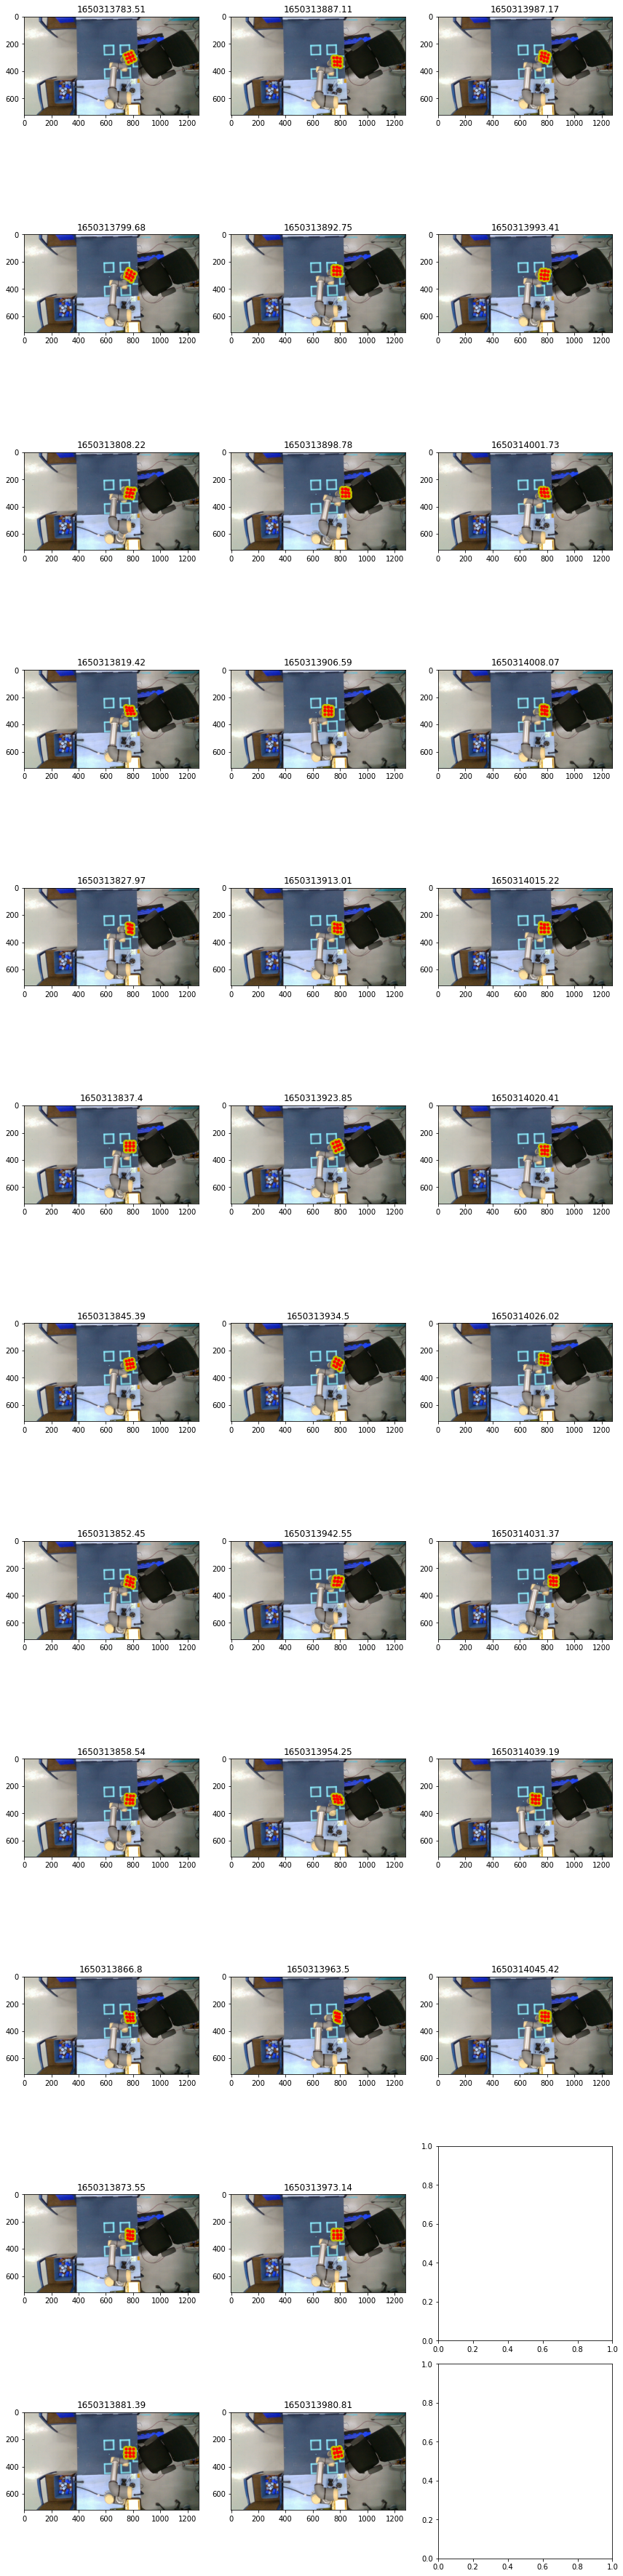

In [9]:
fig, ax = plt.subplots(12, 3, figsize=(12, 50), tight_layout=True)
xi = 0
yi = 0
for image in images:
    im = cv2.imread(os.path.join(scenedir, f'{image["image_id"]}.png'))
    ax[xi, yi].imshow(im)
    ax[xi, yi].plot(image['p_img'][:, 0], image['p_img'][:, 1], 'y.', markersize=16)
    q = projection(T_base_in_cam @ image['T_ee_in_base'] @ T_tag_in_ee, image['p_tag'])
    ax[xi, yi].plot(q[:, 0], q[:, 1], 'r.', markersize=6)
    ax[xi, yi].set_title(f'{image["image_id"]}')
    xi += 1
    if xi == 12:
        xi = 0
        yi += 1

Show aggregate results.

mean error (pixels) = 0.36
min error (pixels) = 0.03
max error (pixels) = 1.10
median error (pixels) = 0.34


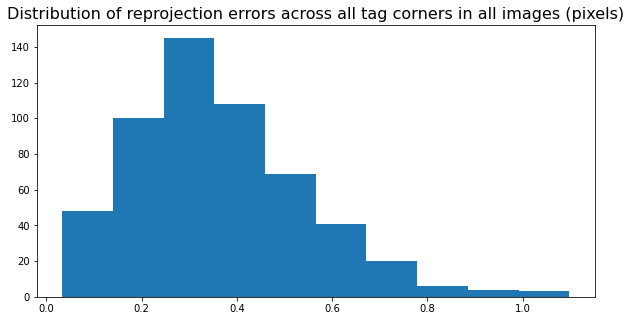

In [10]:
errs = []
for image in images:
    q = projection(T_base_in_cam @ image['T_ee_in_base'] @ T_tag_in_ee, image['p_tag'])
    err = np.sqrt(np.sum((q - image['p_img'])**2, axis=1))
    errs.extend(err.tolist())
    
plt.figure(figsize=(10, 5))
plt.hist(errs)
plt.title('Distribution of reprojection errors across all tag corners in all images (pixels)',
          fontsize=16)

print(f'mean error (pixels) = {np.mean(errs):.2f}')
print(f'min error (pixels) = {np.min(errs):.2f}')
print(f'max error (pixels) = {np.max(errs):.2f}')
print(f'median error (pixels) = {np.median(errs):.2f}')

Show worst results.

Text(0.5, 1.0, '1650314031.37 : maximum reprojection error was 1.10 pixels')

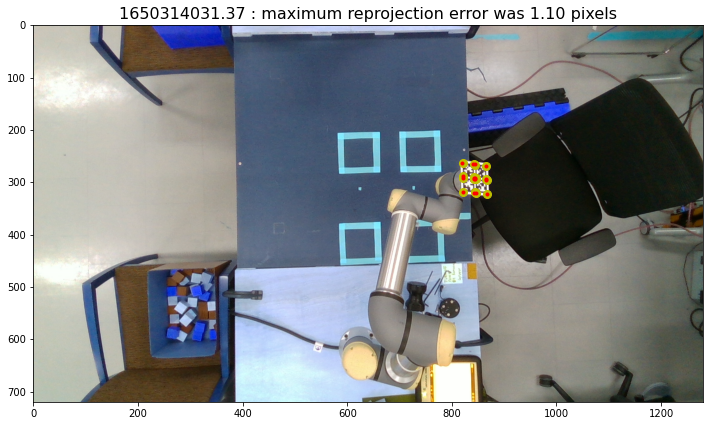

In [11]:
# Find image with tag corner that has maximum reprojection error
max_err = 0
image_with_max_err = None
for image in images:
    q = projection(T_base_in_cam @ image['T_ee_in_base'] @ T_tag_in_ee, image['p_tag'])
    cur_max_err = np.sqrt(np.sum((q - image['p_img'])**2, axis=1)).max()
    if cur_max_err > max_err:
        max_err = cur_max_err
        image_with_max_err = image

# Show that image
plt.figure(figsize=(12, 12))
im = cv2.imread(os.path.join(scenedir, f'{image_with_max_err["image_id"]}.png'))
plt.imshow(im)
plt.plot(image_with_max_err['p_img'][:, 0], image_with_max_err['p_img'][:, 1], 'y.', markersize=16)
q = projection(T_base_in_cam @ image_with_max_err['T_ee_in_base'] @ T_tag_in_ee, image_with_max_err['p_tag'])
plt.plot(q[:, 0], q[:, 1], 'r.', markersize=6)
plt.title(f'{image_with_max_err["image_id"]} : maximum reprojection error was {max_err:.2f} pixels',
          fontsize=16)

Possible sources of error in this analysis:

* Errors in tag corner detection.
* Errors in robot pose (how sensitive are these results to small errors in position and orientation of tool frame?).
* Errors in the tag template (how sure are we that it was printed exactly to scale?).

Other possible sources of error when applying these results to transformation and projection of part poses:

* Errors in the mapping from $x, y, \psi$ to pose.

In particular, take a look at the transformation matrix that describes the tag frame with respect to the base frame:

In [24]:
print(T_tag_in_ee)

[[ 3.54974862e-03 -5.97192157e-04  9.99993521e-01  2.77485232e-03]
 [-3.53279611e-02  9.99375512e-01  7.22229277e-04  3.53269689e-03]
 [-9.99369468e-01 -3.53302959e-02  3.52643426e-03  4.60507234e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


You'll note that the axes of these two frames are *not* aligned. That is to say, the $z$ axis of both the tag frame and the base frame are not orthogonal to the same horizontal plane, as was assumed by "the mapping." These sorts of errors, although small, may lead to significant errors in reprojected parts.

In [38]:
r01 = np.array([.04, 0, 0])
r02 = np.array([.04, -.04, 0])
r03 = np.array([0, -.04, 0])
print(np.matmul(T_tag_in_ee[0:3, 0:3], np.transpose(r01)))
print(T_tag_in_ee[0:3, [3]].reshape(1,3))
print(np.matmul(T_tag_in_ee[0:3, 0:3], np.transpose(r01)) + T_tag_in_ee[0:3, [3]].reshape(1,3))

[ 0.00014199 -0.00141312 -0.03997478]
[[0.00277485 0.0035327  0.04605072]]
[[0.00291684 0.00211958 0.00607594]]


In [4]:
import numpy as np
T_base_in_cam = np.array([[-0.040524961066899304, -0.9986312055640854, 0.03306914142199944, -0.052754060341385474], [-0.9991719723340917, 0.04038221760954298, -0.0049724592629000735, -0.5256772148970205], [0.0036303063724650564, -0.033243256035516, -0.9994406531911695, 1.7684893025670605], [0.0, 0.0, 0.0, 1.0]])
T_tag_in_ee = np.array([[0.0035497486217645428, -0.0005971921567004103, 0.9999935213021389, 0.0027748523161179985], [-0.03532796108104282, 0.9993755117825969, 0.0007222292774974704, 0.00353269689256951], [-0.999369468440265, -0.035330295934239295, 0.0035264342643053104, 0.04605072336563019], [0.0, 0.0, 0.0, 1.0]])
T_ee_in_base = np.array([[ -0.0069757, 0.0125239, -0.9998972, -0.545548274154], [0.0250246, 0.9996106, 0.0123458, -0.0147334007294], [0.9996625, -0.0249359, -0.0072863, 0.23062040362], [0, 0, 0, 1]])
T_tag_in_cam = np.matmul(T_base_in_cam, np.matmul(T_ee_in_base, T_tag_in_ee))
print(T_tag_in_cam)

T_tag01_in_tag00 = np.array([[1, 0, 0, .04], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
T_tag01_in_cam = np.matmul(T_tag_in_cam, T_tag01_in_tag00)
print(T_tag01_in_cam)

T_tag02_in_tag00 = np.array([[1, 0, 0, .04], [0, 1, 0, -.04], [0, 0, 1, 0], [0, 0, 0, 1]])
T_tag02_in_cam = np.matmul(T_tag_in_cam, T_tag02_in_tag00)
print(T_tag02_in_cam)

T_tag03_in_tag00 = np.array([[1, 0, 0, 0], [0, 1, 0, -.04], [0, 0, 1, 0], [0, 0, 0, 1]])
T_tag03_in_cam = np.matmul(T_tag_in_cam, T_tag03_in_tag00)
print(T_tag03_in_cam)

[[ 0.00740925 -0.99994276  0.00772692 -0.01052695]
 [-0.99995144 -0.00735862  0.00655492  0.06381729]
 [-0.00649753 -0.0077751  -0.99994862  1.53385253]
 [ 0.          0.          0.          1.        ]]
[[ 0.00740925 -0.99994276  0.00772692 -0.01023058]
 [-0.99995144 -0.00735862  0.00655492  0.02381923]
 [-0.00649753 -0.0077751  -0.99994862  1.53359263]
 [ 0.          0.          0.          1.        ]]
[[ 0.00740925 -0.99994276  0.00772692  0.02976713]
 [-0.99995144 -0.00735862  0.00655492  0.02411357]
 [-0.00649753 -0.0077751  -0.99994862  1.53390363]
 [ 0.          0.          0.          1.        ]]
[[ 0.00740925 -0.99994276  0.00772692  0.02947076]
 [-0.99995144 -0.00735862  0.00655492  0.06411163]
 [-0.00649753 -0.0077751  -0.99994862  1.53416354]
 [ 0.          0.          0.          1.        ]]


In [3]:
import numpy as np
r01 = np.array([.085, -.04, 0]) # (tag1 corner2)
r02 = np.array([0, .045, 0]) # (tag2 corner0)
r03 = np.array([.085, .045, 0]) # (tag3 corner1)
T_tag_in_ee = np.array([[0.0035497486217645428, -0.0005971921567004103, 0.9999935213021389, 0.0027748523161179985], [-0.03532796108104282, 0.9993755117825969, 0.0007222292774974704, 0.00353269689256951], [-0.999369468440265, -0.035330295934239295, 0.0035264342643053104, 0.04605072336563019], [0.0, 0.0, 0.0, 1.0]])
print(np.matmul(T_tag_in_ee[0:3, 0:3], np.transpose(r03)))
print(T_tag_in_ee[0:3, [3]].reshape(1,3))
print(np.matmul(T_tag_in_ee[0:3, 0:3], np.transpose(r03)) + T_tag_in_ee[0:3, [3]].reshape(1,3))

[ 0.00027485  0.04196902 -0.08653627]
[[0.00277485 0.0035327  0.04605072]]
[[ 0.00304971  0.04550172 -0.04048554]]


In [4]:
import numpy as np
T_base_in_cam = np.array([[-0.040524961066899304, -0.9986312055640854, 0.03306914142199944, -0.052754060341385474], [-0.9991719723340917, 0.04038221760954298, -0.0049724592629000735, -0.5256772148970205], [0.0036303063724650564, -0.033243256035516, -0.9994406531911695, 1.7684893025670605], [0.0, 0.0, 0.0, 1.0]])
T_tag_in_ee = np.array([[0.0035497486217645428, -0.0005971921567004103, 0.9999935213021389, 0.0027748523161179985], [-0.03532796108104282, 0.9993755117825969, 0.0007222292774974704, 0.00353269689256951], [-0.999369468440265, -0.035330295934239295, 0.0035264342643053104, 0.04605072336563019], [0.0, 0.0, 0.0, 1.0]])
T_ee_in_base = np.array([[ -0.0069757, 0.0125239, -0.9998972, -0.545548274154], [0.0250246, 0.9996106, 0.0123458, -0.0147334007294], [0.9996625, -0.0249359, -0.0072863, 0.23062040362], [0, 0, 0, 1]])
T_tag_in_cam = np.matmul(T_base_in_cam, np.matmul(T_ee_in_base, T_tag_in_ee))
print(T_tag_in_cam)

# tag1 corner2
T_tag01_in_tag00 = np.array([[1, 0, 0, .085], [0, 1, 0, -.045], [0, 0, 1, 0], [0, 0, 0, 1]])
T_tag01_in_cam = np.matmul(T_tag_in_cam, T_tag01_in_tag00)
print(T_tag01_in_cam)

# tag2 corner0
T_tag02_in_tag00 = np.array([[1, 0, 0, 0], [0, 1, 0, .045], [0, 0, 1, 0], [0, 0, 0, 1]])
T_tag02_in_cam = np.matmul(T_tag_in_cam, T_tag02_in_tag00)
print(T_tag02_in_cam)

# tag3 corner1
T_tag03_in_tag00 = np.array([[1, 0, 0, .085], [0, 1, 0, .045], [0, 0, 1, 0], [0, 0, 0, 1]])
T_tag03_in_cam = np.matmul(T_tag_in_cam, T_tag03_in_tag00)
print(T_tag03_in_cam)

[[ 0.00740925 -0.99994276  0.00772692 -0.01052695]
 [-0.99995144 -0.00735862  0.00655492  0.06381729]
 [-0.00649753 -0.0077751  -0.99994862  1.53385253]
 [ 0.          0.          0.          1.        ]]
[[ 0.00740925 -0.99994276  0.00772692  0.03510026]
 [-0.99995144 -0.00735862  0.00655492 -0.02084745]
 [-0.00649753 -0.0077751  -0.99994862  1.53365012]
 [ 0.          0.          0.          1.        ]]
[[ 0.00740925 -0.99994276  0.00772692 -0.05552437]
 [-0.99995144 -0.00735862  0.00655492  0.06348615]
 [-0.00649753 -0.0077751  -0.99994862  1.53350265]
 [ 0.          0.          0.          1.        ]]
[[ 0.00740925 -0.99994276  0.00772692 -0.05489458]
 [-0.99995144 -0.00735862  0.00655492 -0.02150972]
 [-0.00649753 -0.0077751  -0.99994862  1.53295036]
 [ 0.          0.          0.          1.        ]]
